In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# --- Configuration ---
# Data parameters (N_GENES, N_BC_SAMPLES_TRAIN, N_NORMAL_SAMPLES_TRAIN will be updated from input data)
N_GENES = 60000 # Placeholder, will be updated
N_BC_SAMPLES_TRAIN = 96 # Placeholder, will be updated
N_NORMAL_SAMPLES_TRAIN = 32 # Placeholder, will be updated
N_VALIDATION_SAMPLES = 100
LABEL_BC = 1
LABEL_NORMAL = 0

# Feature selection parameters
TOP_N_DE_GENES = 2000
LOG2FC_THRESHOLD = 1.0 # log2FC > 2 or log2FC < -2

# MLP parameters
INPUT_FEATURES = None # Will be set after feature selection
HIDDEN_LAYER_1_SIZE = 256
HIDDEN_LAYER_2_SIZE = 32 # Set to 0 or None for a single hidden layer
DROPOUT_RATE = 0.4
OUTPUT_SIZE = 2 # BC or Normal

# Training parameters
LEARNING_RATE = 0.001
EPOCHS = 100 # Epochs for initial training
BATCH_SIZE = 32
USE_BOOTSTRAP = True

# Fine-tuning parameters
PERFORM_FINETUNING = True # Set to True to enable fine-tuning step
N_FINETUNE_SAMPLES = 10 # Small dataset for fine-tuning
FINETUNING_EPOCHS = 50 # Fewer epochs for fine-tuning
FINETUNING_LEARNING_RATE = 0.001 # Typically smaller LR for fine-tuning

# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [3]:
# --- 0. Utility Functions ---
def simulate_tpm_data_generic(n_samples, gene_names_list, is_cancer=False, label_prefix="S"):
    """
    Simulates TPM expression data for validation or fine-tuning against a specific gene list.
    Samples are rows, genes are columns.
    """
    n_genes_local = len(gene_names_list)
    data = np.random.lognormal(mean=3, sigma=1.5, size=(n_samples, n_genes_local))
    if is_cancer:
        n_de_genes_sim = int(n_genes_local * 0.05) # Simulate some DE genes
        de_indices = np.random.choice(n_genes_local, n_de_genes_sim, replace=False)
        for i in range(n_samples): # Iterate through samples
            data[i, de_indices] *= np.random.uniform(3, 10, size=len(de_indices))
    data = np.clip(data, 0, 10000)
    sample_ids = [f"{label_prefix}{i+1}" for i in range(n_samples)]
    df = pd.DataFrame(data, columns=gene_names_list, index=sample_ids)
    return df

# --- 1. Unsupervised Feature selection ---
def normalize_by_total_tpm(tpm_df):
    """
    Normalizes TPM data (samples as rows, genes as columns)
    by dividing by total TPM per sample and multiplying by 1e6.
    """
    total_tpm_per_sample = tpm_df.sum(axis=1)
    total_tpm_per_sample[total_tpm_per_sample == 0] = 1 # Avoid division by zero
    normalized_df = tpm_df.apply(lambda gene_column: (gene_column / total_tpm_per_sample) * 1e6, axis=0)
    return normalized_df

def perform_de_analysis_ttest(data_bc_norm, data_normal_norm):
    """
    Performs DE analysis using t-test.
    Assumes data_bc_norm and data_normal_norm are DataFrames (samples x genes),
    normalized by total TPM.
    """
    print("\nPerforming DE analysis using t-test...")
    gene_names = data_bc_norm.columns
    # log2fc_values = [] # Not directly used later, log2fc is calculated and stored in DataFrame
    p_values_ttest = []
    epsilon = 1e-6 # For log2FC calculation, to avoid log(0)

    mean_bc = data_bc_norm.mean(axis=0) + epsilon
    mean_normal = data_normal_norm.mean(axis=0) + epsilon
    log2fc = np.log2(mean_bc / mean_normal)

    for gene in gene_names:
        bc_expressions = data_bc_norm[gene].dropna()
        normal_expressions = data_normal_norm[gene].dropna()
        
        if len(bc_expressions) < 2 or len(normal_expressions) < 2:
            p_val = 1.0 
        else:
            ttest_result = stats.ttest_ind(bc_expressions, normal_expressions, equal_var=False, nan_policy='omit')
            p_val = ttest_result.pvalue
        p_values_ttest.append(p_val if not np.isnan(p_val) else 1.0)

    de_results = pd.DataFrame({
        'gene': gene_names,
        'log2FC': log2fc.values, 
        'p_value': p_values_ttest
    })
    
    de_results = de_results.sort_values(by='p_value', ascending=True)
    print(f"DE analysis with t-test complete. Top 5 results:\n{de_results.head()}")
    return de_results

def select_unsupervised_features(de_results, top_n, log2fc_thresh):
    """Selects features based on p-value and log2FC."""
    significant_genes = de_results[
        (de_results['p_value'] < 0.05) &
        (abs(de_results['log2FC']) > log2fc_thresh)
    ]
    
    if len(significant_genes) < top_n:
        print(f"Warning: Found only {len(significant_genes)} genes with p < 0.05 and |log2FC| > {log2fc_thresh}.")
        print(f"Taking top {top_n} genes by p-value among those with |log2FC| > {log2fc_thresh} (if available).")
        potential_genes = de_results[abs(de_results['log2FC']) > log2fc_thresh]
        selected = potential_genes.nsmallest(top_n, 'p_value')
    else:
        selected = significant_genes.nsmallest(top_n, 'p_value')
    
    print(f"Selected {len(selected)} genes from DE analysis.")
    if len(selected) == 0:
        print("Warning: No genes selected from DE analysis. Consider relaxing criteria or checking data.")
        return []
    print(f"Top 5 selected DE genes:\n{selected.head()}")
    return list(selected['gene'])

# --- 2. Knowledge-based Feature Selection ---
def get_knowledge_based_features_simulated(all_gene_names_list):
    """Simulates fetching known breast cancer markers from the provided gene list."""
    print("\nFetching simulated knowledge-based features...")
    known_markers_placeholder_ensg = []
    if not all_gene_names_list: 
        print("Warning: all_gene_names_list is empty. Cannot select knowledge-based features.")
        return []

    num_markers_to_pick = min(10, len(all_gene_names_list) // 1000 + 5) 
    if len(all_gene_names_list) > num_markers_to_pick:
        indices_to_pick = np.linspace(0, len(all_gene_names_list) - 1, num_markers_to_pick, dtype=int)
        for idx in indices_to_pick:
            known_markers_placeholder_ensg.append(all_gene_names_list[idx])
    else: 
        known_markers_placeholder_ensg = all_gene_names_list[:num_markers_to_pick]

    known_markers_placeholder_ensg = list(set(known_markers_placeholder_ensg))
    print(f"Found {len(known_markers_placeholder_ensg)} simulated knowledge-based marker genes.")
    if known_markers_placeholder_ensg:
        print(f"Example markers: {known_markers_placeholder_ensg[:min(5, len(known_markers_placeholder_ensg))]}")
    return known_markers_placeholder_ensg

# --- 3. PyTorch MLP Model ---
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate):
        super(MLPClassifier, self).__init__()
        self.network = nn.Sequential()
        self.network.add_module("fc1", nn.Linear(input_size, hidden_size1))
        self.network.add_module("silu1", nn.SiLU())
        self.network.add_module("dropout1", nn.Dropout(dropout_rate))

        if hidden_size2 and hidden_size2 > 0:
            self.network.add_module("fc2", nn.Linear(hidden_size1, hidden_size2))
            self.network.add_module("silu2", nn.SiLU())
            self.network.add_module("dropout2", nn.Dropout(dropout_rate))
            self.network.add_module("fc_out", nn.Linear(hidden_size2, output_size))
        else:
            self.network.add_module("fc_out", nn.Linear(hidden_size1, output_size))
            
    def forward(self, x):
        return self.network(x)

# --- 4. Training, Fine-tuning and Evaluation ---
def train_model_core(model, data_loader, criterion, optimizer, device, epochs, phase_name="Training"):
    """Core training loop used by both initial training and fine-tuning."""
    model.train() 
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(data_loader)
        if (epoch + 1) % (max(1, epochs // 10)) == 0 or epoch == 0: # Print more frequently for shorter epochs
             print(f"{phase_name} - Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")
    print(f"{phase_name} finished.")


def train_model(model, train_loader, criterion, optimizer, device, epochs, use_bootstrap=False, X_train_full=None, y_train_full=None):
    print("\nStarting initial model training...")
    if use_bootstrap and X_train_full is not None and y_train_full is not None:
        # If bootstrap, we resample each epoch, so the core loop needs to be inside the epoch loop
        model.train()
        for epoch in range(epochs):
            X_resampled, y_resampled = resample(X_train_full, y_train_full, 
                                                stratify=y_train_full, 
                                                random_state=RANDOM_SEED + epoch,
                                                n_samples=len(y_train_full))
            resampled_dataset = TensorDataset(torch.FloatTensor(X_resampled).to(device), 
                                              torch.LongTensor(y_resampled).to(device))
            current_train_loader = DataLoader(resampled_dataset, batch_size=BATCH_SIZE, shuffle=True)
            
            epoch_loss_bootstrap = 0
            for inputs, labels in current_train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss_bootstrap += loss.item()
            avg_epoch_loss_bootstrap = epoch_loss_bootstrap / len(current_train_loader)
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Initial Training (Bootstrap) - Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss_bootstrap:.4f}")
        print("Initial Training (Bootstrap) finished.")
    else:
        # Non-bootstrap: use the provided train_loader directly
        train_model_core(model, train_loader, criterion, optimizer, device, epochs, phase_name="Initial Training")


def finetune_model(model, finetune_loader, criterion, device, epochs, learning_rate):
    print("\nStarting model fine-tuning...")
    # Use a new optimizer for fine-tuning, often with a smaller learning rate
    optimizer_finetune = optim.Adam(model.parameters(), lr=learning_rate)
    train_model_core(model, finetune_loader, criterion, optimizer_finetune, device, epochs, phase_name="Fine-tuning")


def evaluate_model(model, data_loader, criterion, device, dataset_name="Validation"):
    """Evaluates the model and returns metrics along with labels and probabilities for curve plotting."""
    print(f"\nEvaluating model on {dataset_name} set...")
    model.eval(); total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for inputs, labels_batch in data_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs); loss = criterion(outputs, labels_batch); total_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, LABEL_BC].cpu().numpy()) # Prob for positive class (BC)

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, labels=[LABEL_BC], pos_label=LABEL_BC, zero_division=0)
    recall = recall_score(all_labels, all_preds, labels=[LABEL_BC], pos_label=LABEL_BC, zero_division=0)
    f1 = f1_score(all_labels, all_preds, labels=[LABEL_BC], pos_label=LABEL_BC, zero_division=0)
    auc_val_metric = "N/A"
    if len(np.unique(all_labels)) > 1:
        try: auc_val_metric = f"{roc_auc_score(all_labels, all_probs):.4f}"
        except ValueError as e: print(f"Could not calculate ROC AUC for {dataset_name}: {e}.")
    else: print(f"ROC AUC calculation skipped for {dataset_name}: Only one class in true labels.")

    print(f"{dataset_name} Set Performance:\n  Avg Loss: {avg_loss:.4f}\n  Accuracy: {accuracy:.4f}\n  Precision (BC): {precision:.4f}\n  Recall (BC): {recall:.4f}\n  F1-score (BC): {f1:.4f}\n  ROC AUC: {auc_val_metric}")
    return accuracy, precision, recall, f1, auc_val_metric, all_labels, all_probs # Return labels and probs


In [4]:
from sklearn.model_selection import train_test_split # Though not strictly for train/test, can be useful for stratified selection

def split_validation_data(valid_df, valid_label, n_samples_per_class=5, random_state=None):
    """
    Splits a validation dataset into a fine-tuning subset and a remaining validation set.

    Args:
        valid_df (pd.DataFrame): DataFrame with samples as rows and features as columns.
        valid_label (list or pd.Series): List or Series of binary labels (0 or 1).
        n_samples_per_class (int): Number of samples to select for each class for the fine-tuning set.
        random_state (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - fine_tune_df (pd.DataFrame): DataFrame for fine-tuning.
            - fine_tune_label (pd.Series): Labels for fine-tuning.
            - remaining_valid_df (pd.DataFrame): DataFrame for the remaining validation set.
            - remaining_valid_label (pd.Series): Labels for the remaining validation set.
            Returns None for all if data is insufficient.
    """
    if not isinstance(valid_df, pd.DataFrame):
        raise ValueError("valid_df must be a pandas DataFrame.")
    if not isinstance(valid_label, (list, pd.Series)):
        raise ValueError("valid_label must be a list or pandas Series.")
    if len(valid_df) != len(valid_label):
        raise ValueError("valid_df and valid_label must have the same number of samples.")

    # Convert valid_label to a pandas Series if it's a list for easier manipulation
    if isinstance(valid_label, list):
        valid_label_series = pd.Series(valid_label, index=valid_df.index)
    else:
        # Ensure index alignment if valid_label is already a Series
        valid_label_series = valid_label.reset_index(drop=True)
        temp_valid_df = valid_df.reset_index(drop=True)
        valid_label_series.index = temp_valid_df.index


    # Separate data by class
    df_class_0 = valid_df[valid_label_series == 0]
    labels_class_0 = valid_label_series[valid_label_series == 0]

    df_class_1 = valid_df[valid_label_series == 1]
    labels_class_1 = valid_label_series[valid_label_series == 1]

    # Check if we have enough samples in each class
    if len(df_class_0) < n_samples_per_class or len(df_class_1) < n_samples_per_class:
        print(f"Warning: Not enough samples for one or both classes. "
              f"Class 0 has {len(df_class_0)} samples, Class 1 has {len(df_class_1)} samples. "
              f"Required {n_samples_per_class} for each for fine-tuning.")
        print("Returning None for all datasets.")
        return None, None, None, None

    # Sample n_samples_per_class from each class for the fine-tuning set
    # Using sample method for random selection
    fine_tune_df_class_0 = df_class_0.sample(n=n_samples_per_class, random_state=random_state)
    fine_tune_labels_class_0 = labels_class_0.loc[fine_tune_df_class_0.index]

    fine_tune_df_class_1 = df_class_1.sample(n=n_samples_per_class, random_state=random_state)
    fine_tune_labels_class_1 = labels_class_1.loc[fine_tune_df_class_1.index]

    # Combine the sampled data to create the fine-tuning set
    fine_tune_df = pd.concat([fine_tune_df_class_0, fine_tune_df_class_1])
    fine_tune_label = pd.concat([fine_tune_labels_class_0, fine_tune_labels_class_1])

    # Shuffle the fine-tuning set (optional, but good practice)
    fine_tune_df = fine_tune_df.sample(frac=1, random_state=random_state)
    fine_tune_label = fine_tune_label.loc[fine_tune_df.index]

    # Create the remaining validation set by dropping the fine-tuning samples
    remaining_indices = valid_df.index.difference(fine_tune_df.index)
    remaining_valid_df = valid_df.loc[remaining_indices]
    remaining_valid_label = valid_label_series.loc[remaining_indices]
    
    # Shuffle the remaining validation set as well
    remaining_valid_df = remaining_valid_df.sample(frac=1, random_state=random_state)
    remaining_valid_label = remaining_valid_label.loc[remaining_valid_df.index]


    print(f"Original dataset size: {len(valid_df)}")
    print(f"Fine-tuning set size: {len(fine_tune_df)} (Class 0: {sum(fine_tune_label == 0)}, Class 1: {sum(fine_tune_label == 1)})")
    print(f"Remaining validation set size: {len(remaining_valid_df)} (Class 0: {sum(remaining_valid_label == 0)}, Class 1: {sum(remaining_valid_label == 1)})")

    return fine_tune_df, fine_tune_label, remaining_valid_df, remaining_valid_label

def plot_roc_pr_curves(y_true, y_probs, plot_title_suffix):
    """Plots ROC and Precision-Recall curves."""
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs, pos_label=LABEL_BC)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {plot_title_suffix}')
    plt.legend(loc="lower right"); plt.grid(True); plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_probs, pos_label=LABEL_BC)
    avg_precision = average_precision_score(y_true, y_probs, pos_label=LABEL_BC)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - {plot_title_suffix}')
    plt.legend(loc="lower left"); plt.grid(True); plt.show()

In [5]:
# Load expression and metadata
tpm_norm = pd.read_csv("pnas_normal_tpm.txt", sep='\t')
tpm_norm['gene_id'] = tpm_norm.index
readcounts_norm = pd.read_csv("pnas_normal_readcounts.txt", sep='\t')
readcounts_norm['gene_id'] = readcounts_norm.index

# Load expression and metadata
tpm = pd.read_csv("pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

In [6]:
# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_norm = tpm_norm.set_index('gene_id')
readcounts_norm = readcounts_norm.set_index('gene_id')

shared_genes = set(readcounts_norm.index) & set(readcounts_filtered.index) & set(tpm.index) & set(tpm_norm.index)

tpm_norm = tpm_norm[tpm_norm.index.isin(shared_genes)]
readcounts_norm = readcounts_norm[readcounts_norm.index.isin(shared_genes)]
tpm = tpm[tpm.index.isin(shared_genes)]
readcounts_filtered = readcounts_filtered[readcounts_filtered.index.isin(shared_genes)]

tpm_combined = pd.concat([tpm_norm, tpm], axis=1)

sample_order = tpm_combined.columns
labels = [0 for i in range(32)] + [1 for i in range(96)]

In [7]:
# Transpose DataFrame: samples as rows, genes as columns
data_transposed = tpm_combined.T
all_gene_names = list(tpm_combined.index) # Gene names from the original index

# Update global N_GENES based on actual data
N_GENES = len(all_gene_names)
print(f"Number of genes found: {N_GENES}")
if N_GENES == 0:
    print("Error: No genes found in the input data. Exiting.")
    exit()

Number of genes found: 60675


In [8]:
# Separate BC and Normal samples based on column name convention (now index names after transpose)
bc_sample_names = [idx_name for idx_name in data_transposed.index if idx_name.startswith('C')]
normal_sample_names = [idx_name for idx_name in data_transposed.index if idx_name.startswith('N')]

tpm_bc_train_raw = data_transposed.loc[bc_sample_names]
tpm_normal_train_raw = data_transposed.loc[normal_sample_names]

# Update global sample counts based on actual data
N_BC_SAMPLES_TRAIN = len(tpm_bc_train_raw)
N_NORMAL_SAMPLES_TRAIN = len(tpm_normal_train_raw)

if N_BC_SAMPLES_TRAIN == 0 or N_NORMAL_SAMPLES_TRAIN == 0:
    print("Error: Not enough BC or Normal samples found based on C*/N* naming. Exiting.")
    print(f"Found {N_BC_SAMPLES_TRAIN} BC samples and {N_NORMAL_SAMPLES_TRAIN} Normal samples.")
    exit()
    
print(f"Loaded training data: {N_BC_SAMPLES_TRAIN} BC samples, {N_NORMAL_SAMPLES_TRAIN} Normal samples.")
print(f"Shape of BC training data (Samples x Genes): {tpm_bc_train_raw.shape}")
print(f"Shape of Normal training data (Samples x Genes): {tpm_normal_train_raw.shape}")

Loaded training data: 96 BC samples, 32 Normal samples.
Shape of BC training data (Samples x Genes): (96, 60675)
Shape of Normal training data (Samples x Genes): (32, 60675)


In [9]:
# Normalize by total TPM (for DE analysis)
# These DataFrames have samples as rows, genes as columns
tpm_bc_train_norm_total = normalize_by_total_tpm(tpm_bc_train_raw)
tpm_normal_train_norm_total = normalize_by_total_tpm(tpm_normal_train_raw)
print("TPM data normalized by total TPM per sample for DE analysis.")

# --- 2. Unsupervised Feature Selection (on training data) ---
print("\n--- Step 2: Unsupervised Feature Selection (T-test) ---")
de_results = perform_de_analysis_ttest(tpm_bc_train_norm_total, tpm_normal_train_norm_total)
unsupervised_selected_genes = select_unsupervised_features(de_results, TOP_N_DE_GENES, LOG2FC_THRESHOLD)
if not unsupervised_selected_genes:
    print("Stopping: No unsupervised features selected. Check DE analysis parameters or data.")
    exit()

TPM data normalized by total TPM per sample for DE analysis.

--- Step 2: Unsupervised Feature Selection (T-test) ---

Performing DE analysis using t-test...
DE analysis with t-test complete. Top 5 results:
                  gene    log2FC       p_value
31369  ENSG00000232035  3.614878  1.208643e-21
60110  ENSG00000281344  0.639329  2.610948e-17
23582  ENSG00000216184 -9.031285  2.623634e-13
6202   ENSG00000130032 -1.715355  3.453349e-13
995    ENSG00000067066 -1.018551  7.289087e-13
Selected 2000 genes from DE analysis.
Top 5 selected DE genes:
                  gene    log2FC       p_value
31369  ENSG00000232035  3.614878  1.208643e-21
23582  ENSG00000216184 -9.031285  2.623634e-13
6202   ENSG00000130032 -1.715355  3.453349e-13
995    ENSG00000067066 -1.018551  7.289087e-13
25056  ENSG00000222604 -2.047593  4.036419e-12


In [10]:
#knowledge_selected_genes = get_knowledge_based_features_simulated(all_gene_names) # Pass the actual gene list    
#final_feature_list = list(set(unsupervised_selected_genes + knowledge_selected_genes))
final_feature_list = list(set(unsupervised_selected_genes ))
print(f"\nTotal unique features after DE: {len(final_feature_list)}")
if not final_feature_list:
    print("Stopping: No features in the final list. Check selection steps.")
    exit()

INPUT_FEATURES = len(final_feature_list)
print(f"Input features for MLP: {INPUT_FEATURES}")


Total unique features after DE: 2000
Input features for MLP: 2000


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
# --- 4. Prepare Data for PyTorch Model ---
print("\n--- Step 4: Preparing Data for PyTorch Model ---")
# Combine raw TPM data (samples as rows, all genes as columns)
X_train_raw_combined = pd.concat([tpm_bc_train_raw, tpm_normal_train_raw])
y_train_labels = np.array([LABEL_BC] * N_BC_SAMPLES_TRAIN + [LABEL_NORMAL] * N_NORMAL_SAMPLES_TRAIN)

# Select the final features from the combined raw training data
# Ensure all selected features are present in the columns
missing_features = [f for f in final_feature_list if f not in X_train_raw_combined.columns]
if missing_features:
    print(f"Warning: {len(missing_features)} selected features are not in the training data columns. They will be ignored.")
    final_feature_list = [f for f in final_feature_list if f in X_train_raw_combined.columns]
    INPUT_FEATURES = len(final_feature_list) # Update input features count
    if not final_feature_list:
        print("Error: No usable features left after checking against data columns. Exiting.")
        exit()
    print(f"Adjusted input features for MLP: {INPUT_FEATURES}")


X_train_selected_features_raw = X_train_raw_combined[final_feature_list]

# Feature Scaling (StandardScaler) for MLP input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected_features_raw) # Fit and transform on training data
print("Training data features selected and scaled.")

train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled).to(device), 
                              torch.LongTensor(y_train_labels).to(device))
# If not using bootstrap per epoch, the train_loader can be defined once here
# If using bootstrap, train_model will create its own loader per epoch from X_train_scaled, y_train_labels
train_loader_for_non_bootstrap = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 5. Build and Train MLP Model ---
print("\n--- Step 5: Building and Training MLP Model ---")
model = MLPClassifier(INPUT_FEATURES, HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, OUTPUT_SIZE, DROPOUT_RATE).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


--- Step 4: Preparing Data for PyTorch Model ---
Training data features selected and scaled.

--- Step 5: Building and Training MLP Model ---
MLPClassifier(
  (network): Sequential(
    (fc1): Linear(in_features=2000, out_features=256, bias=True)
    (silu1): SiLU()
    (dropout1): Dropout(p=0.4, inplace=False)
    (fc2): Linear(in_features=256, out_features=32, bias=True)
    (silu2): SiLU()
    (dropout2): Dropout(p=0.4, inplace=False)
    (fc_out): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [13]:
train_model(model, train_loader_for_non_bootstrap, criterion, optimizer, device, EPOCHS, 
                use_bootstrap=USE_BOOTSTRAP, 
                X_train_full=X_train_scaled if USE_BOOTSTRAP else None, 
                y_train_full=y_train_labels if USE_BOOTSTRAP else None)


Starting initial model training...
Initial Training (Bootstrap) - Epoch [1/100], Loss: 0.4845
Initial Training (Bootstrap) - Epoch [10/100], Loss: 0.0003
Initial Training (Bootstrap) - Epoch [20/100], Loss: 0.0001
Initial Training (Bootstrap) - Epoch [30/100], Loss: 0.0001
Initial Training (Bootstrap) - Epoch [40/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [50/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [60/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [70/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [80/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [90/100], Loss: 0.0000
Initial Training (Bootstrap) - Epoch [100/100], Loss: 0.0000
Initial Training (Bootstrap) finished.


Validation data features selected and scaled using training set's scaler.

--- Step 7: Testing Performance on Validation Set ---

Evaluating model on Validation (Post-Initial Training) set...
Validation (Post-Initial Training) Set Performance:
  Avg Loss: 0.0000
  Accuracy: 1.0000
  Precision (BC): 1.0000
  Recall (BC): 1.0000
  F1-score (BC): 1.0000
  ROC AUC: 1.0000


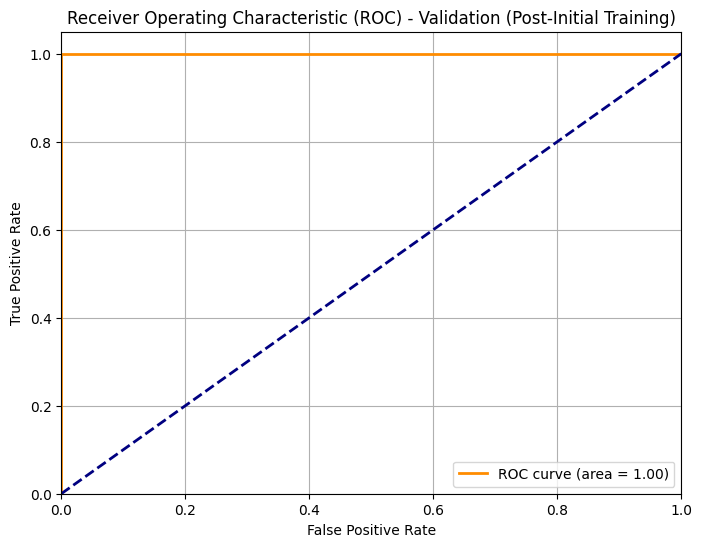

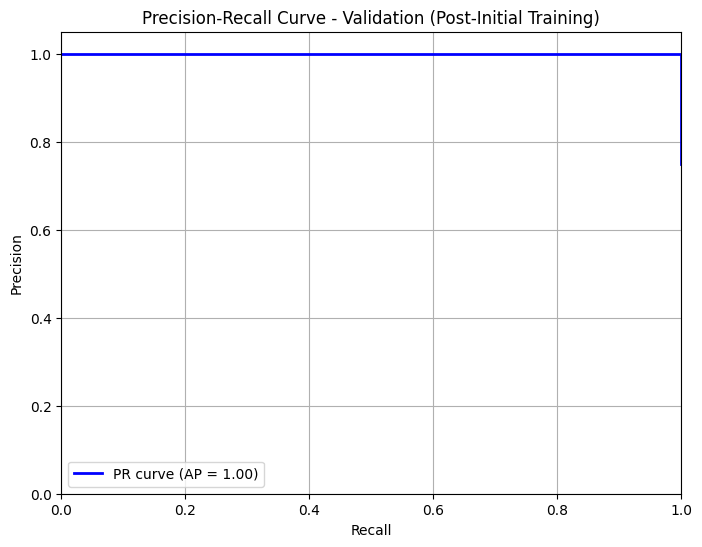


--- Script Finished ---


In [19]:
# test on training dataset 
# proof
# Apply the *fitted* scaler from the training data
X_val_scaled = scaler.transform(X_train_selected_features_raw)
print("Validation data features selected and scaled using training set's scaler.")

val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled).to(device), 
                            torch.LongTensor(y_train_labels).to(device))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 7. Test Performance on Validation Set ---
print("\n--- Step 7: Testing Performance on Validation Set ---")
_, _, _, _, _, val_labels_initial, val_probs_initial = evaluate_model(model, val_loader, criterion, device, "Validation (Post-Initial Training)")
plot_roc_pr_curves(val_labels_initial, val_probs_initial, "Validation (Post-Initial Training)")
print("\n--- Script Finished ---")

In [20]:
# --- Optional: Fine-tuning Step ---
tpm_valid = pd.read_csv("validation_exon_tpm", sep='\t')
tpm_valid_norm_total = normalize_by_total_tpm(tpm_valid.T)

valid_cancer_patient = pd.read_csv("validation_bc_meta.csv")

cancer_patients = list(valid_cancer_patient['Mapping ID'])

tpm_df = tpm_valid_norm_total.loc[:,final_feature_list]

valid_labels = tpm_df.index.map(
    lambda x: 1 if x in cancer_patients else 0
)

In [21]:
ft_df_few, ft_lbl_few, rem_df_few, rem_lbl_few = split_validation_data(
        tpm_df,
        valid_labels.to_list(),
        n_samples_per_class=8,
        random_state=42
    )

Original dataset size: 161
Fine-tuning set size: 16 (Class 0: 8, Class 1: 8)
Remaining validation set size: 145 (Class 0: 70, Class 1: 75)



--- Testing Performance on Validation Set before FT---

Evaluating model on Validation (Post-Initial Training) set...
Validation (Post-Initial Training) Set Performance:
  Avg Loss: 3.4721
  Accuracy: 0.5034
  Precision (BC): 1.0000
  Recall (BC): 0.0400
  F1-score (BC): 0.0769
  ROC AUC: 0.6415


/var/folders/3c/vppvsw_945q0kl2pq0fmkc240000gn/T/ipykernel_12868/2001701222.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.LongTensor(rem_lbl_few).to(device))


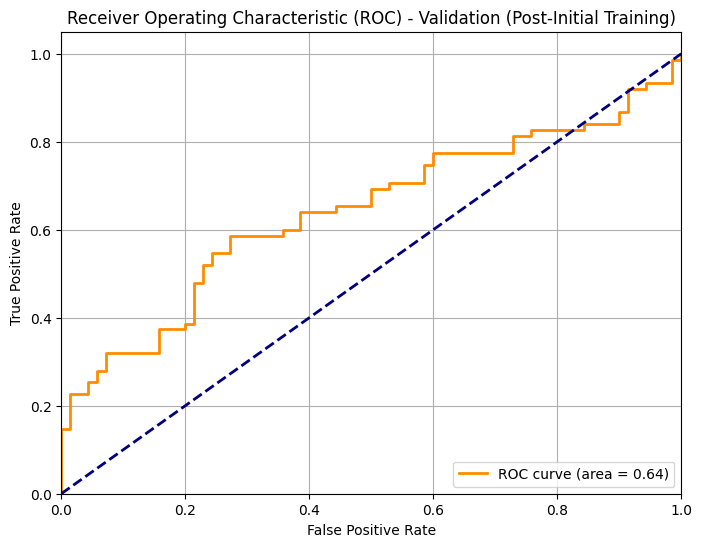

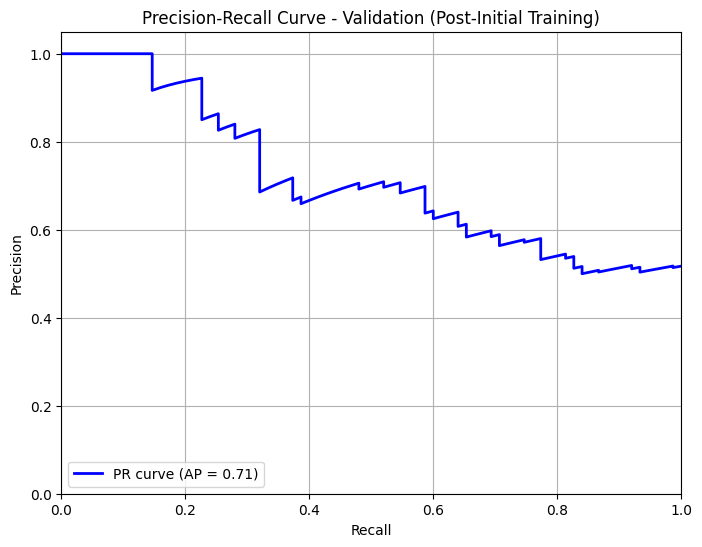

In [22]:
# test on training dataset 
rem_scaled = scaler.transform(rem_df_few)

val_dataset = TensorDataset(torch.FloatTensor(rem_scaled).to(device), 
                            torch.LongTensor(rem_lbl_few).to(device))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 7. Test Performance on Validation Set ---
print("\n--- Testing Performance on Validation Set before FT---")
_, _, _, _, _, val_labels_initial, val_probs_initial = evaluate_model(model, val_loader, criterion, device, "Validation (Post-Initial Training)")
plot_roc_pr_curves(val_labels_initial, val_probs_initial, "Validation (Post-Initial Training)")

In [23]:
ft_scaled = scaler.transform(ft_df_few)

finetune_dataset = TensorDataset(torch.FloatTensor(ft_scaled).to(device),
                                 torch.LongTensor(ft_lbl_few).to(device))
finetune_loader = DataLoader(finetune_dataset, batch_size=max(1, N_FINETUNE_SAMPLES // 2), shuffle=True) # Adjust batch size for small N

/var/folders/3c/vppvsw_945q0kl2pq0fmkc240000gn/T/ipykernel_12868/1233382563.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.LongTensor(ft_lbl_few).to(device))



--- Step 9: Fine-tuning Model ---

Starting model fine-tuning...
Fine-tuning - Epoch [1/50], Loss: 1.3386
Fine-tuning - Epoch [5/50], Loss: 0.0061
Fine-tuning - Epoch [10/50], Loss: 0.0023
Fine-tuning - Epoch [15/50], Loss: 0.0008
Fine-tuning - Epoch [20/50], Loss: 0.0002
Fine-tuning - Epoch [25/50], Loss: 0.0002
Fine-tuning - Epoch [30/50], Loss: 0.0002
Fine-tuning - Epoch [35/50], Loss: 0.0001
Fine-tuning - Epoch [40/50], Loss: 0.0004
Fine-tuning - Epoch [45/50], Loss: 0.0002
Fine-tuning - Epoch [50/50], Loss: 0.0001
Fine-tuning finished.

--- Step 10: Testing Performance on Validation Set (After Fine-tuning) ---

Evaluating model on Validation (Post-Fine-tuning) set...
Validation (Post-Fine-tuning) Set Performance:
  Avg Loss: 1.8756
  Accuracy: 0.6069
  Precision (BC): 0.7368
  Recall (BC): 0.3733
  F1-score (BC): 0.4956
  ROC AUC: 0.6855


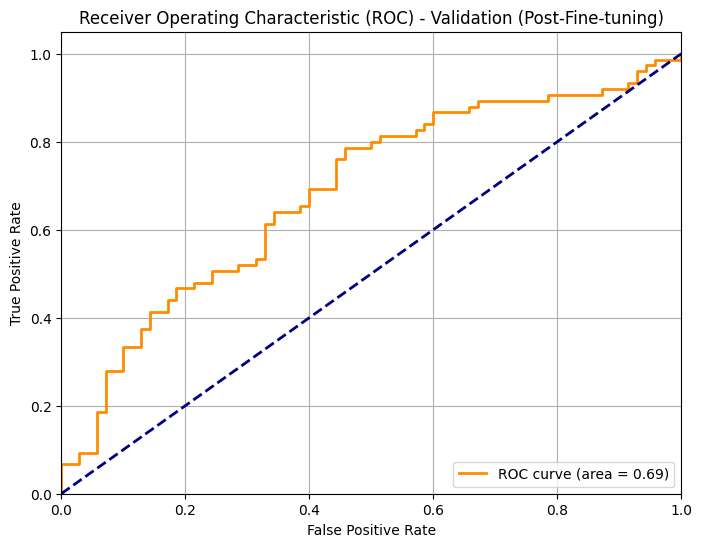

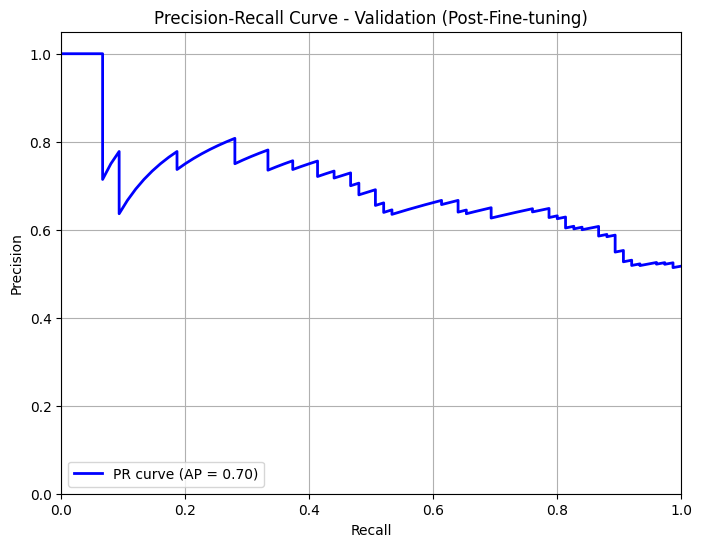

In [24]:
print("\n--- Step 9: Fine-tuning Model ---")
finetune_model(model, finetune_loader, criterion, device, FINETUNING_EPOCHS, FINETUNING_LEARNING_RATE)

print("\n--- Step 10: Testing Performance on Validation Set (After Fine-tuning) ---")
_, _, _, _, _, val_labels_initial, val_probs_initial = evaluate_model(model, val_loader, criterion, device, "Validation (Post-Fine-tuning)")
plot_roc_pr_curves(val_labels_initial, val_probs_initial, "Validation (Post-Fine-tuning)")

In [18]:
# --- 6. Prepare Validation Data ---
print("\n--- Step 6: Preparing Validation Data (Simulated) ---")
# Simulate validation data using the gene list from the loaded training data
n_val_bc = N_VALIDATION_SAMPLES // 2
n_val_normal = N_VALIDATION_SAMPLES - n_val_bc

# Use the 'all_gene_names' from your actual data for consistency in simulation
tpm_val_bc_raw = simulate_tpm_data_for_validation(n_val_bc, all_gene_names, is_cancer=True)
tpm_val_normal_raw = simulate_tpm_data_for_validation(n_val_normal, all_gene_names, is_cancer=False)

X_val_raw_combined = pd.concat([tpm_val_bc_raw, tpm_val_normal_raw])
y_val_labels = np.array([LABEL_BC] * n_val_bc + [LABEL_NORMAL] * n_val_normal)

print(f"Simulated validation data: {n_val_bc} BC samples, {n_val_normal} Normal samples, using {len(all_gene_names)} genes.")

# Select the *same* final_feature_list (derived from training) from validation data
# Ensure all features are present in validation data columns
val_missing_features = [f for f in final_feature_list if f not in X_val_raw_combined.columns]
if val_missing_features:
     # This should ideally not happen if all_gene_names was used correctly for simulation
    print(f"Warning: {len(val_missing_features)} selected features are not in the validation data columns. This is unexpected.")
    # Option: filter them out, or error. For now, filter.
    current_val_features = [f for f in final_feature_list if f in X_val_raw_combined.columns]
    X_val_selected_features_raw = X_val_raw_combined[current_val_features]
else:
    X_val_selected_features_raw = X_val_raw_combined[final_feature_list]


if X_val_selected_features_raw.shape[1] != INPUT_FEATURES:
    print(f"Warning: Validation feature count ({X_val_selected_features_raw.shape[1]}) "
          f"differs from model input features ({INPUT_FEATURES}). This may cause errors.")
    # This might happen if some features from final_feature_list were not in X_val_raw_combined.columns
    # A more robust way is to reindex, filling missing with 0 or mean, but for now, this highlights a potential issue.
    # Forcing columns to match, filling missing with 0 (example of handling)
    X_val_selected_features_raw = X_val_selected_features_raw.reindex(columns=final_feature_list, fill_value=0)

X_val_selected_features_raw


--- Step 6: Preparing Validation Data (Simulated) ---
Simulated validation data: 50 BC samples, 50 Normal samples, using 60675 genes.


,ENSG00000263404,ENSG00000251041,ENSG00000222604,ENSG00000206806,ENSG00000239767,ENSG00000224918,ENSG00000271992,ENSG00000243055,ENSG00000272145,ENSG00000265593,...,ENSG00000243914,ENSG00000277083,ENSG00000229594,ENSG00000271290,ENSG00000213117,ENSG00000223418,ENSG00000227836,ENSG00000280092,ENSG00000231906,ENSG00000200890
0,80.190148,2.506263,3.343823,46.584363,40.296082,394.439324,75.824492,28.889303,215.743063,1.474990,...,21.427821,0.136423,1.394565,85.765738,18.182239,13.754560,22.713372,15.041182,6.753190,30.319901
1,2.363373,15.066280,6.793788,60.734515,95.222994,11.501285,40.719346,50.310214,768.118647,40.585152,...,472.119729,14.597384,2.795054,21.933907,15.429703,19.166483,322.430599,4.627307,45.784632,20.530349
2,1.179069,11.983512,10.514227,14.376007,50.991767,6.885097,178.658114,14.696383,5.788140,74.506473,...,102.760483,10.994750,325.479346,67.656539,34.246892,42.180244,6.469548,2.037551,217.220481,15.632472
3,21.166961,306.957021,12.425984,39.070599,887.770410,6.654844,123.820688,5.978888,143.367385,49.218711,...,2.356974,25.981883,70.026762,122.727059,4.682860,27.986057,41.572432,5.825396,31.119011,39.105292
4,88.600579,20.480696,84.127826,11.968249,21.224973,10.941757,3.517865,48.065648,2.953059,13.372943,...,130.325043,11.857590,4.199216,95.647867,125.282401,10.730796,18.045171,7.719497,26.233389,7.921124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,21.359837,2.038031,20.805583,1.773168,64.604444,1.267000,6.874052,1.514328,11.396176,262.719057,...,5.669203,7.404163,13.308848,37.463351,8.926543,5.731412,216.414515,6.343374,8.630262,22.636486
46,6.345013,3.357380,10.013930,278.315739,3.265068,3.295639,15.792100,3.223226,206.291205,263.391506,...,51.298342,65.041949,7.553050,4.867742,74.051820,50.115644,30.789013,14.044491,82.429342,16.198966
47,496.091201,56.765737,63.629046,46.348912,3.033685,10.315830,9.929038,4.484551,77.732181,293.303936,...,23.522195,0.555058,122.885413,27.922205,22.799264,0.128535,1.029098,5.863247,5.368020,13.499739
48,60.896450,27.469861,4.880424,80.057856,120.295608,6.762323,10.089527,32.807762,15.720185,5.846116,...,107.808718,20.317743,13.204085,21.294709,16.271391,10.581488,9.798458,2.888099,3.340737,13.084733
